In [ ]:
!pip install transformers

In [ ]:
!pip install huggingface_hub

In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199770 sha256=4ab126b4d9e30fad21d49e5290568e58260950595c4395e5667fde5f3cbb2661
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
import glob
import pandas as pd
import csv
import re
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from transformers import AutoTokenizer, AutoModel, AdamW
import torch

import fasttext
from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
import matplotlib.pyplot as plt

import pandas as pd
import json

In [ ]:
def transform_column(df_column):
  scaler = MinMaxScaler()
  scores = np.array(df_column)
  scores = scores.reshape(-1,1)
  scaler.fit(scores)
  scores = scaler.transform(scores)
  scores = np.float32(scores)
  return scores

In [ ]:
model_path = hf_hub_download(repo_id="facebook/fasttext-language-identification", filename="model.bin")
model = fasttext.load_model(model_path)

def is_romanian_post(row):
  if model.predict(change_n_to_space(row["title"]))[0][0] == '__label__ron_Latn':
      return True
  return False

def change_n_to_space(text):
  return text.replace('\n', ' ')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.bin:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

In [ ]:
df_train = pd.read_csv("train.csv")
df_validation = pd.read_csv("validation.csv")
df_test = pd.read_csv("test.csv")

In [ ]:
# Get the lists of contents and their labels.
### TRAIN ###
contents_train = df_train.full_text.values
labels_train = df_train.label.values


### VALIDATION ###
contents_validation = df_validation.full_text.values
labels_validation = df_validation.label.values

### TEST ###
contents_test = df_test.full_text.values
labels_test = df_test.label.values

In [ ]:
def clean_text (text):
  text = text.lower()
  text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
  text = re.sub(r'\s+', ' ', text)
  return text

contents_train = [clean_text(text) for text in contents_train]
contents_validation = [clean_text(text) for text in contents_validation]
contents_test = [clean_text(text) for text in contents_test]


In [ ]:
# fasttext embeddings for the dataset
! pip install pandas numpy scikit-learn gensim nltk

# Tokenization using nltk

import nltk

nltk.download('punkt')
from gensim.models import FastText
from nltk.tokenize import word_tokenize

print("TRAIN")
# Print the original sentence.
print(' Original: ', contents_train[0])
contents_train_tokenized = [word_tokenize(text) for text in contents_train]
print (contents_train_tokenized[0])

print("VALIDATION")
# Print the original sentence.
print(' Original: ', contents_validation[0])
contents_validation_tokenized = [word_tokenize(text) for text in contents_validation]
print (contents_validation_tokenized[0])

print("TEST")
# Print the original sentence.
print(' Original: ', contents_test[0])
contents_test_tokenized = [word_tokenize(text) for text in contents_test]
print (contents_test_tokenized[0])

# Train FastText model
fasttext_model = FastText(sentences=contents_train_tokenized, vector_size=300, window=3, min_count=1, workers=4, sg=1)

# Generate embeddings for training, validation, and test sets
def generate_embeddings(contents_tokenized):
    embeddings = []
    for text in contents_tokenized:
        # Calculate the mean of word vectors for each text
        text_vector = np.mean([fasttext_model.wv[word] for word in text if word in fasttext_model.wv] or [np.zeros(300)], axis=0)
        embeddings.append(text_vector)
    embeddings = np.array(embeddings)
    return embeddings

embeddings_train = generate_embeddings(contents_train_tokenized)
embeddings_validation = generate_embeddings(contents_validation_tokenized)
embeddings_test = generate_embeddings(contents_test_tokenized)

# print the shape of the embeddings
print(embeddings_train.shape)
print(embeddings_validation.shape)
print(embeddings_test.shape)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


TRAIN
 Original:  am vreo 11 invite uri dota2 pentru cine vrea si nu are sunt atat de minunat ca le dau gratis la urma urmei cica costa 28 de euro http store steampowered com app 570 edit tot le dau dar imi recitesc titlul si ma simt cat de cat penibil nu sterg dar subliniez berile pe care le am baut de a cursul serii nu ma scuz au fost bune dar mi se invarte camera n juru capului si scriu incredibil de corect e ceva deosebit hai sa facem tinychat edit2 ma bat pe spate pentru hyperlink ul ala de acu un edit m am tarat in pat dar capacitatiile mele de html de clasa a 10 a ma surprind continuu edit3 am uitat sa mentionez azi am fost la politie sa mi refac buletinul pentru ca s matur acum problema e ca mi au luat prezentul buletin si acum il astept pe cel nou peste o saptamana marea problema e ca n am dovada sau copie dupa buletin deci evident ca prau de beat pe drum spre casa ma opreste politia pentru prima oara in viata mea ca sa ma legitimze dintr o masina care nu era de politie si evi

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

def compute_metrics(y_pred, y_true):

  y_pred = y_pred.flatten()
  macro_f1 = f1_score(y_true, y_pred, average='macro')
  # Popular - label 1
  TP_pop = 0 # y_true = 1 si y_pred = 1
  FP_pop = 0 # y_true = 0 si y_pred = 1
  FN_pop = 0 # y_true = 1 si y_pred = 0
  # Unpopular - label 0
  TP_unpop = 0 # y_true = 0 si y_pred = 0
  FP_unpop = 0 # y_true = 1 si y_pred = 0
  FN_unpop = 0 # y_true = 0 si y_pred = 1
  n = len(y_pred)
  for index in range(n):
    # Popular
    if y_true[index] == 1:
      if y_pred[index] == 1:
        TP_pop += 1
      if y_pred[index] == 0:
        FN_pop += 1
        FP_unpop += 1
    else:
    # Unpopular y_true[index] == 0
      if y_pred[index] == 0:
        TP_unpop += 1
      if y_pred[index] == 1:
        FN_unpop += 1
        FP_pop += 1

  P_pop = 0 if TP_pop + FP_pop == 0 else TP_pop / (TP_pop + FP_pop)
  R_pop = 0 if TP_pop + FN_pop == 0 else TP_pop / (TP_pop + FN_pop)
  P_unpop = 0 if TP_unpop + FP_unpop == 0 else TP_unpop / (TP_unpop + FP_unpop)
  R_unpop = 0 if TP_unpop + FN_unpop == 0 else TP_unpop / (TP_unpop + FN_unpop)

  return (macro_f1, P_pop, R_pop, P_unpop, R_unpop)

In [ ]:
#train svm model
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

average_training_loss = []

clf = SVC(kernel='linear', C=10)
clf.fit(embeddings_train, labels_train)

# Predict on training set
train_predictions = clf.predict(embeddings_train)

# Calculate training accuracy
training_accuracy = accuracy_score(labels_train, train_predictions)


# evaluate using compute_metrics function

# Predict on validation set
predictions_validation = clf.predict(embeddings_validation)

predicts_validation_reshaped = np.array(predictions_validation).reshape(len (labels_validation), 1)

macro_f1, P_popular, R_popular, P_unpopular, R_unpopular = compute_metrics(predicts_validation_reshaped, labels_validation)
accuracy_validation = accuracy_score(labels_validation, predicts_validation_reshaped)
print("VALIDATION")
print("Accuracy: ", accuracy_validation)
print("Macro F1: ", macro_f1)
print("Popular class: ")
print("Precision: ", P_popular)
print("Recall: ", R_popular)
print("Unpopular class: ")
print("Precision: ", P_unpopular)
print("Recall: ", R_unpopular)

VALIDATION
Accuracy:  0.6677709417889257
Macro F1:  0.6624619073105196
Popular class: 
Precision:  0.7225725094577553
Recall:  0.543127962085308
Unpopular class: 
Precision:  0.6348484848484849
Recall:  0.7920604914933838


In [ ]:
# Prediction on test set

predictions_test = clf.predict(embeddings_test)

predicts_test_reshaped = np.array(predictions_test).reshape(len(labels_test), 1)

macro_f1, P_popular, R_popular, P_unpopular, R_unpopular = compute_metrics(predicts_test_reshaped, labels_test)
accuracy_test = accuracy_score(labels_test, predicts_test_reshaped)

print("TEST")
print("Accuracy:", accuracy_test)
print("Macro F1: ", macro_f1)
print("Popular class: ")
print("Precision: ", P_popular)
print("Recall: ", R_popular)
print("Unpopular class: ")
print("Precision: ", P_unpopular)
print("Recall: ", R_unpopular)

TEST
Accuracy: 0.5644955300127714
Macro F1:  0.5637048252106422
Popular class: 
Precision:  0.5583398590446359
Recall:  0.6083617747440273
Unpopular class: 
Precision:  0.5718283582089553
Recall:  0.5208156329651656


Example  0
Label:  0
Prediction:  0
Text:  reparatii ecrane buna am si eu o intrebare am un ecran mionitor dell s2721hn care din pacate a fost lovit fix in mijloc si sa stricat cred ca deja stiti cum arata un ecran cand arunci cu o maneta de playstation in el hahaeram curios este posibil sa l repar pe undeva sau acuma o mai tin degeaba edit am uitat sa apas shift cand am apasat enter mai voiam sa spun si un multumesc anticipat 3
Words with highest weights: 
         words   weights
180       edit  2.494270
9           sa  2.230300
298       deja  1.824824
16          am  0.871391
85        cand  0.660840
17          ca  0.372937
18         mai  0.347753
8           pe -0.044673
10          cu -0.115635
29        este -0.122125
5           in -0.146870
13         din -0.398241
0           de -0.765735
15        care -0.843456
14          un -0.947252
76           3 -0.993824
32        fost -1.099879
6           si -1.200422
276  multumesc -1.488340
166       cred -1.699339
12           

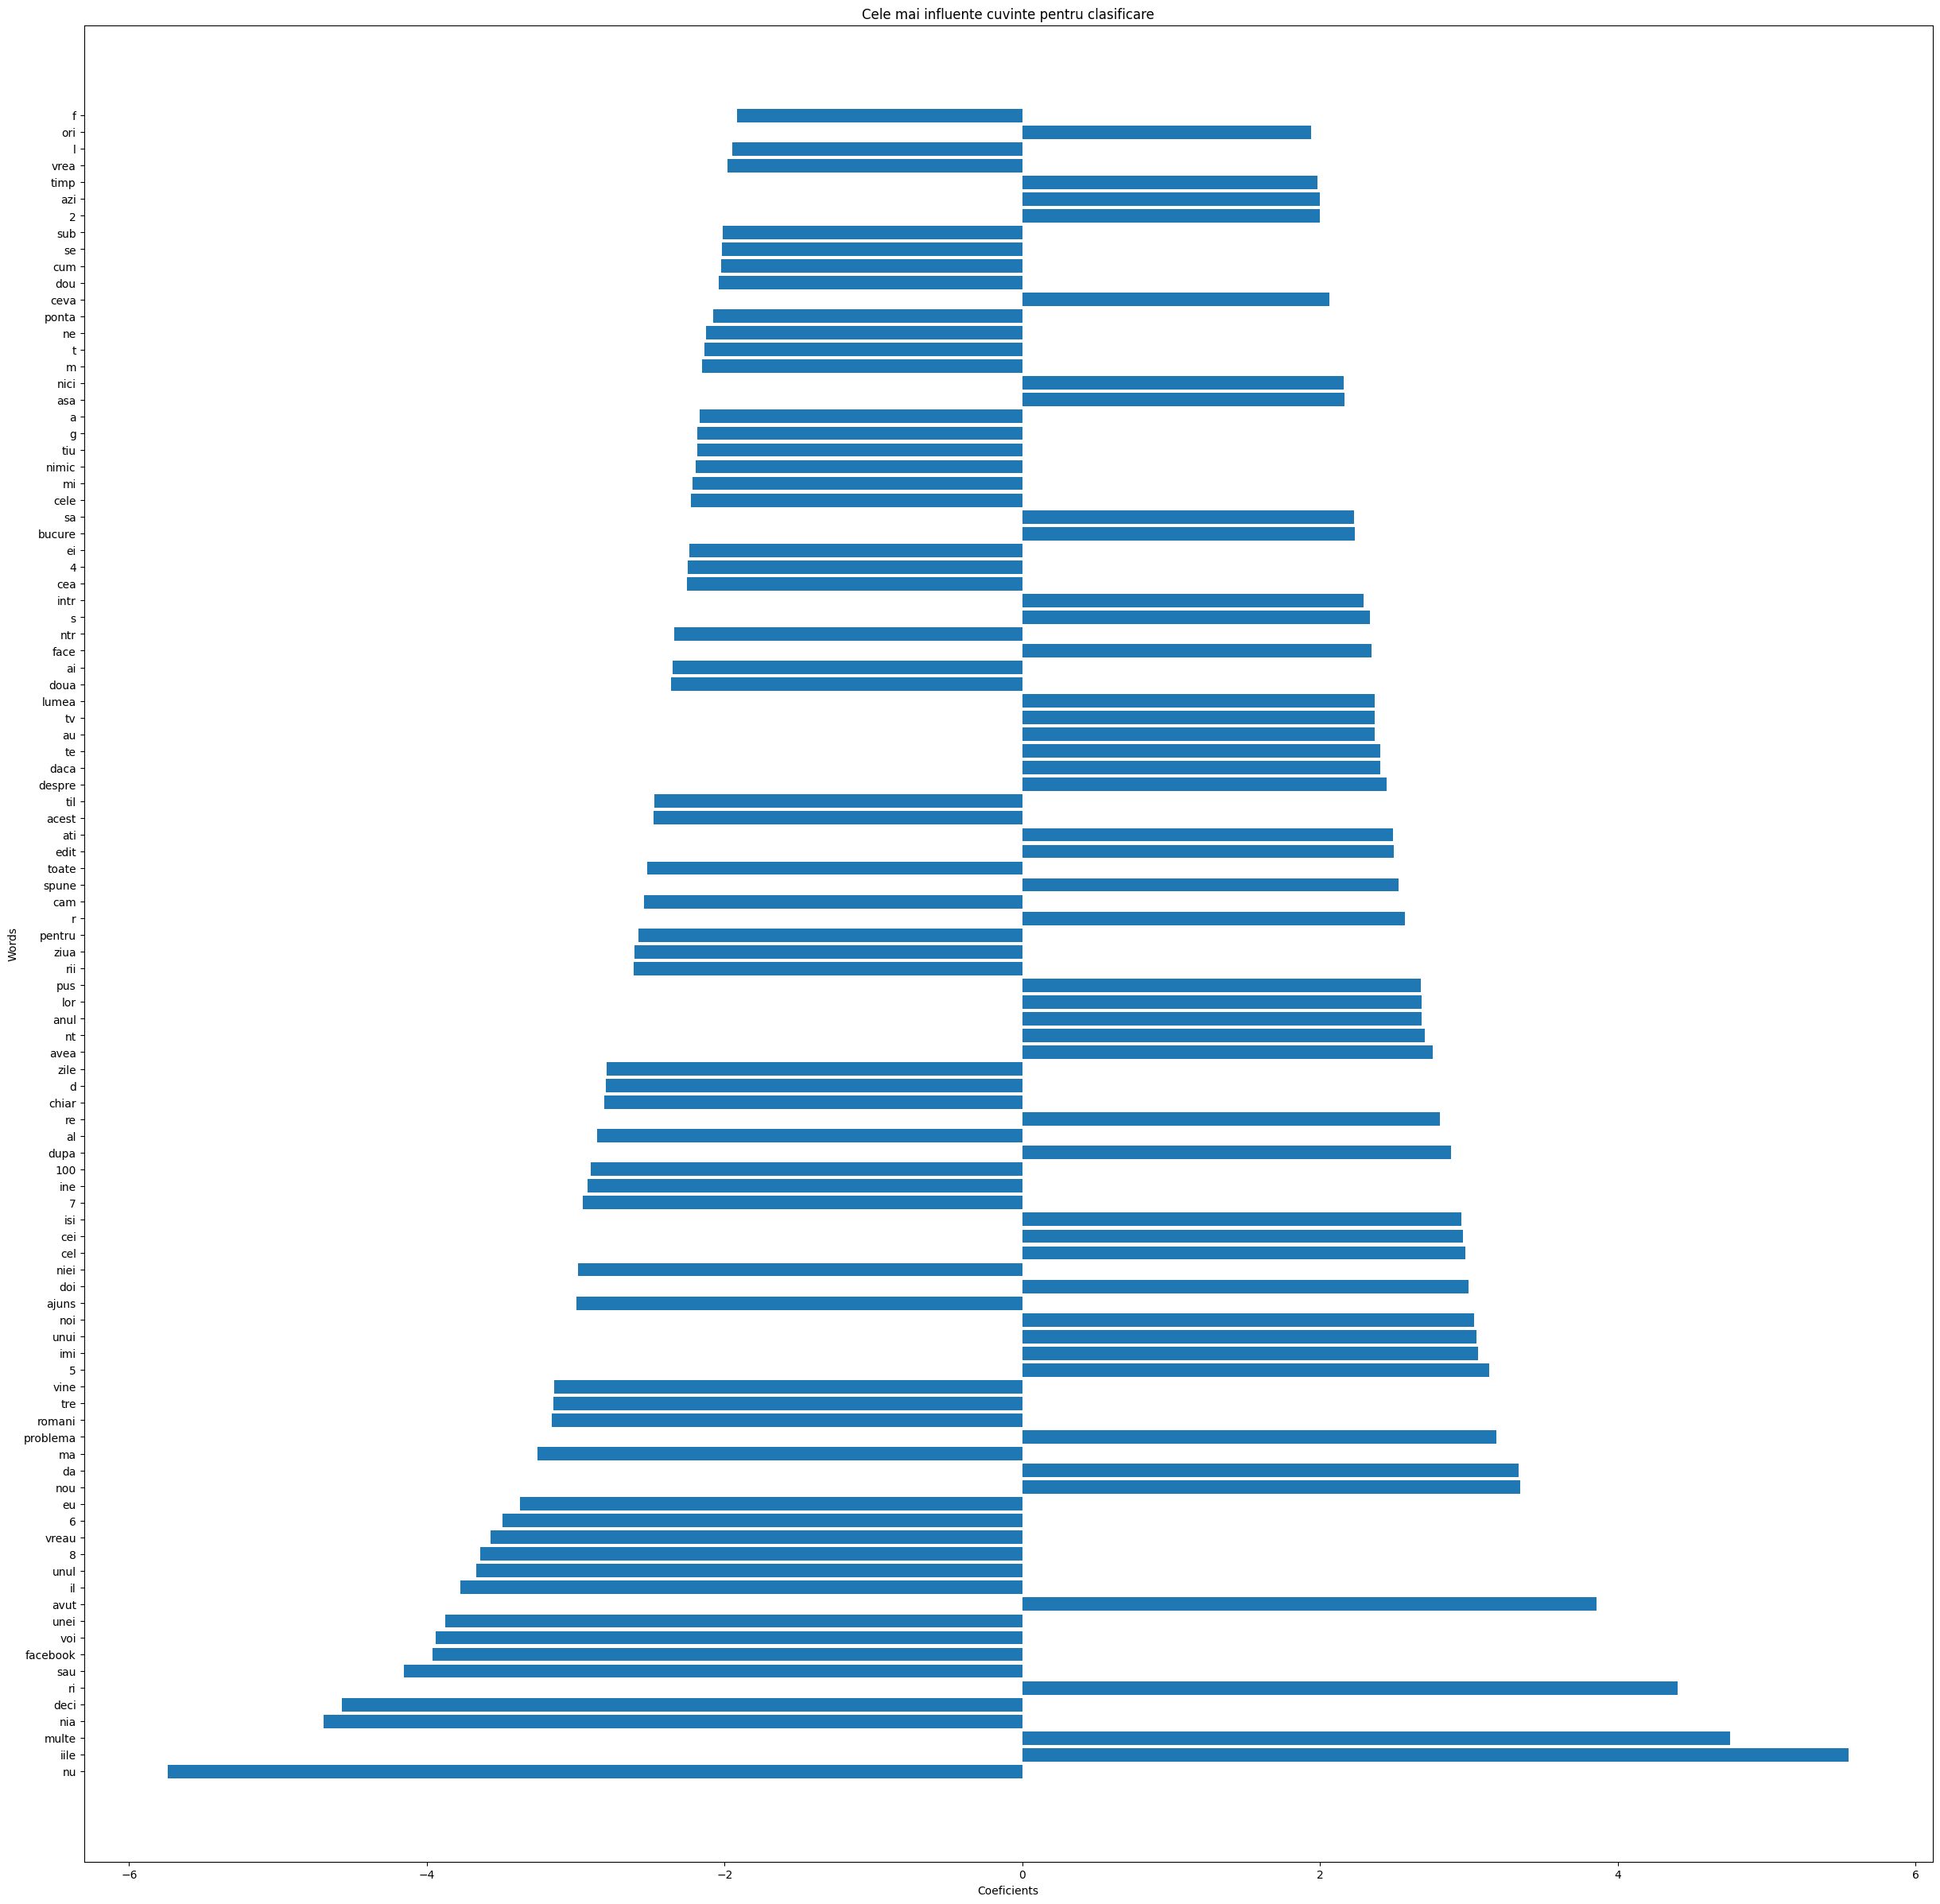

In [ ]:
weights = clf.coef_[0]

# Get the words corresponding to the embeddings.
words = fasttext_model.wv.index_to_key

# Create a dataframe of weights and words.
influential_words_df = pd.DataFrame(list(zip(words, weights)), columns=['words', 'weights'])

# for some examples in the test set, print the words with the highest weights
for i in range(10):
  print("Example ", i)
  print("Label: ", labels_test[i])
  print("Prediction: ", predictions_test[i])
  print("Text: ", contents_test[i])
  print("Words with highest weights: ")
  # print weight for each word
  print(influential_words_df[influential_words_df['words'].isin(contents_test_tokenized[i])].sort_values(by='weights', ascending=False))
  print("\n")

# Sort the DataFrame by the absolute values of weights for better visualization
influential_words_df['abs_weights'] = influential_words_df['weights'].abs()
influential_words_df = influential_words_df.sort_values(by='abs_weights', ascending=False)

# Plot the dataframe.
plt.figure(figsize=(30, 30))
plt.barh(influential_words_df['words'][:100], influential_words_df['weights'][:100])
plt.title('Cele mai influente cuvinte pentru clasificare')
plt.xlabel('Coeficients')
plt.ylabel('Words')
plt.show()